In [1]:
%reload_ext autoreload
%autoreload 2


import numpy as np
from esis.data import level_3
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = [10, 10]


# ESIS Level 3 Data

This document will serve as a record of the methods used to create level 3 data, a test of those methods and their
quality/validity, and a manual for working with the level3 object.


## Internal Alignment Quality

Initial distortion corrections and image co-alignment was done by maximizing the cross-correlation between linearly
 transformed Level 1 ESIS data and the closest AIA 304 image in time.  This gives a mean zero-lag cross-correlation of:


In [2]:
lev_3 = level_3.Level3.from_pickle(level_3.ov_Level3_initial)

normalized_imgs = lev_3.observation.data
normalized_imgs = (normalized_imgs - normalized_imgs.mean(axis = (-2,-1),keepdims=True))/normalized_imgs.std(
    axis=(-2,-1),keepdims=True)

camera_combos = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]
list_cc = []
for lev3_seq,lev1_seq in enumerate(lev_3.lev1_sequences):
    for i,j in camera_combos:
        cc = np.sum(normalized_imgs[lev3_seq,i]*normalized_imgs[lev3_seq,j])/normalized_imgs[lev3_seq,i].size
        list_cc.append(cc)

list_cc = np.array(list_cc)
print(list_cc.mean())



0.9112628773594159


An additional internal co-alignment step was added to account for a small amount of quadratic distortion in the ESIS optical system.
Each channel was quadratically transformed to maximize its cross-correlation to ESIS Camera 2 (my favorite channel).
This gives a mean zero-lag cross-correlations between each channel of:


In [3]:
updated_lev_3 = level_3.Level3.from_pickle(level_3.ov_Level3_updated)
normalized_imgs = updated_lev_3.observation.data
normalized_imgs = (normalized_imgs - normalized_imgs.mean(axis = (-2,-1),keepdims=True))/normalized_imgs.std(
    axis=(-2,-1),keepdims=True)

camera_combos = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]
updated_list_cc = []
for lev3_seq,lev1_seq in enumerate(updated_lev_3.lev1_sequences):
    for i,j in camera_combos:
        cc = np.sum(normalized_imgs[lev3_seq,i]*normalized_imgs[lev3_seq,j])/normalized_imgs[lev3_seq,i].size
        updated_list_cc.append(cc)

updated_list_cc = np.array(updated_list_cc)
print(updated_list_cc.mean())

0.9122099409284763


The mean zero-lag cross correlation is improved, but by examining the ratio of the updated level 3 cubes internal
 alignment to that of the linearly co-aligned data one can see that every image combinations correlation is improved.


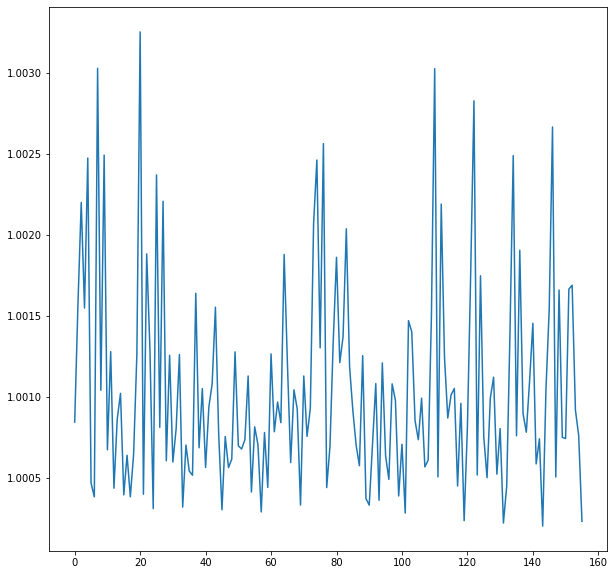

In [4]:
cc_ratio = updated_list_cc / list_cc
fig,ax = plt.subplots()
ax.plot(cc_ratio)
plt.show()

## Vignetting Correction

The original ESIS optical design included an aperture mask at the primary optic to prevent a vignetted optical path.
Unfortunately the primary mask limited ESIS's throughput too much so the mask was removed adding a linear vignetting
in each spectral line.  Since the Level 3 data only considers one spectral line at a time each line considered will be
contaminated by adjacent and overlapping spectral lines.  Luckily each ESIS channel has an O V portion that is uncontaminated
by the adjacent and bright Mg X line.  This portion of the image will be masked and used to correct the linear vignetting
trend.

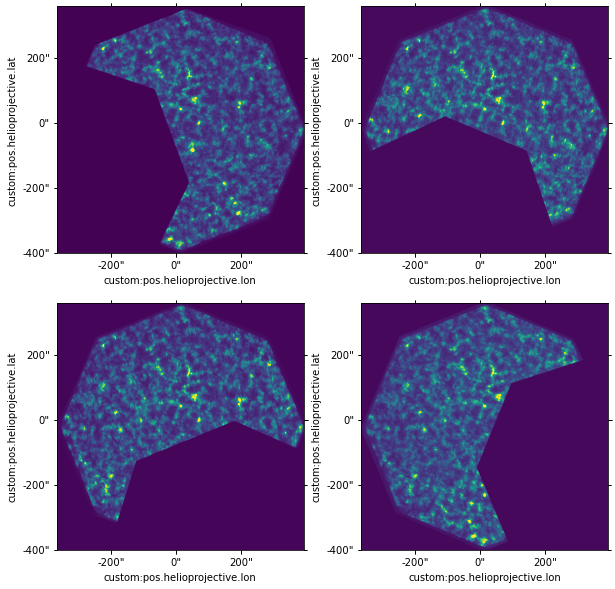

In [5]:
masked_lev3 = level_3.Level3.from_pickle(level_3.ov_Level3_masked)
masked_imgs = masked_lev3.observation.data * masked_lev3.observation.mask
sequence = 15
p = 99.9

#note, required to be able to pickle post plotting ???
wcs_copy = masked_lev3.observation.wcs.copy()
fig , axs = plt.subplots(2,2,subplot_kw={'projection': wcs_copy[sequence,0]})
axs[0,0].imshow(masked_imgs[sequence,0],origin = 'lower', vmax = np.percentile(masked_imgs[sequence,0],p))
axs[0,1].imshow(masked_imgs[sequence,1],origin = 'lower', vmax = np.percentile(masked_imgs[sequence,1],p))
axs[1,0].imshow(masked_imgs[sequence,2],origin = 'lower', vmax = np.percentile(masked_imgs[sequence,2],p))
axs[1,1].imshow(masked_imgs[sequence,3],origin = 'lower', vmax = np.percentile(masked_imgs[sequence,3],p))


Examining the difference of two masked images shows the linear trend from the vignetting very well.  Prior to subtraction
the mean was divided out of each image.

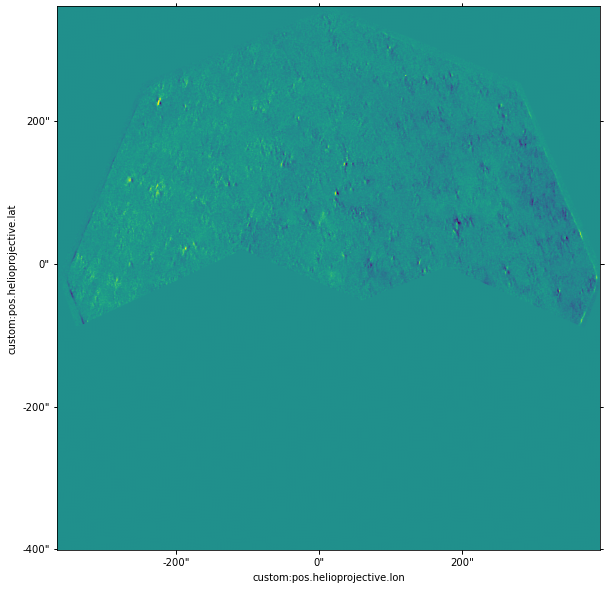

In [6]:

combined_mask = masked_lev3.observation.mask[sequence,1]*masked_lev3.observation.mask[sequence,2]
masked_im1 = masked_imgs[sequence,1]*combined_mask
masked_im2 = masked_imgs[sequence,2]*combined_mask

masked_im1 /= masked_im1.mean()
masked_im2 /= masked_im2.mean()

dif = masked_im1-masked_im2

fig,ax = plt.subplots(subplot_kw={'projection': wcs_copy[sequence,0]})
ax.imshow(dif,vmin = -5, vmax = 5,origin = 'lower')


To correct the vignetting I divided each image by a linearly trending background oriented roughly to the dispersion dimesnion
in each octagon like so:


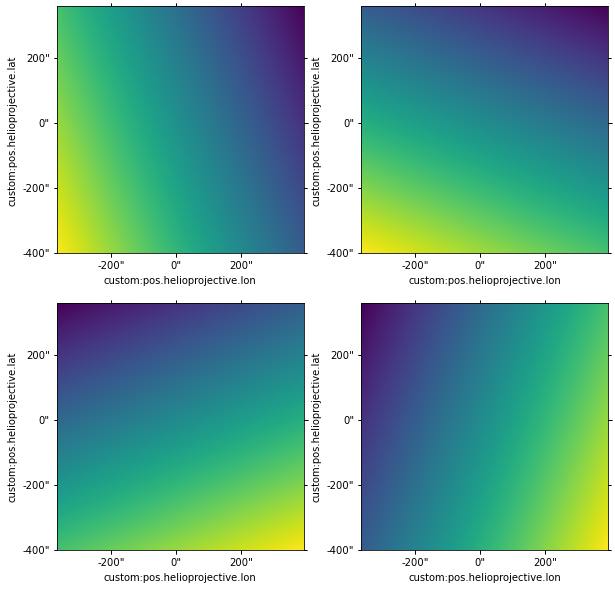

In [7]:
# scales = np.array([0.38341205, 0.31867413, 0.340001  , 0.44604856])
# scales = np.array([0.38848841, 0.33193899, 0.34498025, 0.48747989])
# scales = np.array([0.38831433, 0.33160426, 0.34531125, 0.48770024])
# scales = np.array([0.42759312, 0.33783337, 0.38762052, 0.50163686])
scales = np.array([0.43610222, 0.33961842, 0.38185936, 0.49515337])

vignetting_correction = masked_lev3.correct_vignetting(scale_factor=scales)


fig,axs = plt.subplots(2,2,subplot_kw={'projection': wcs_copy[sequence,0]})
axs[0,0].imshow(vignetting_correction[sequence,0],origin = 'lower')
axs[0,1].imshow(vignetting_correction[sequence,1],origin = 'lower')
axs[1,0].imshow(vignetting_correction[sequence,2],origin = 'lower')
axs[1,1].imshow(vignetting_correction[sequence,3],origin = 'lower')
plt.show()

In order to find the slope of the backgrounds to subtract I fit a line to the difference image column means as a funtion
of row, and then varied each of the 4 scale factors to minimize the least squares slope of each fit.  A total of 29*6 fits
were used in the error. Six difference images per exposure.  After the vignetting correction and mean normalization the
difference images are much flatter.

In [8]:
masked_lev3.observation.data[...] /= vignetting_correction
masked_lev3.observation.data[...] /= masked_lev3.masked_mean_normalization()

combined_mask = masked_lev3.observation.mask[sequence,1]*masked_lev3.observation.mask[sequence,2]
dif = masked_lev3.observation.data[sequence,1]-masked_lev3.observation.data[sequence,2]

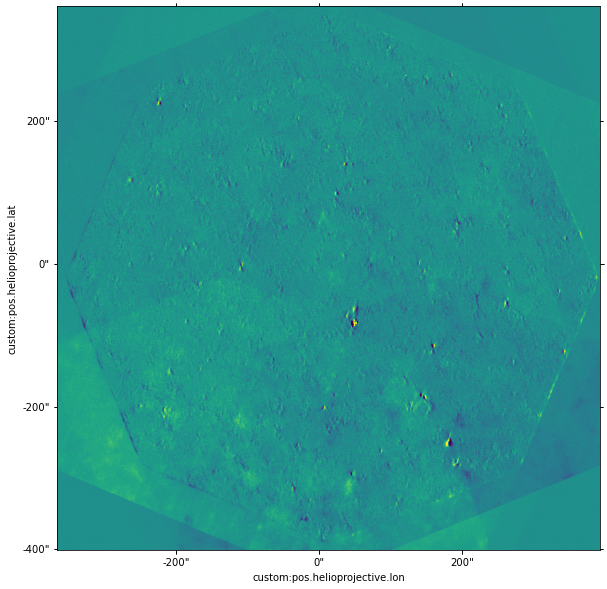

In [9]:
fig,ax = plt.subplots(subplot_kw={'projection': wcs_copy[sequence,0]})
ax.imshow(dif,vmin = -2, vmax = 2,origin = 'lower')

In [10]:




# transform_cube = img_align.TransformCube.from_pickle(masked_lev3.transformation_objects)
# np.savetxt('Camera1.csv',transform_cube.transform_cube[0][0].transform.reshape(2,6),delimiter = ',')
# np.savetxt('Camera2.csv',transform_cube.transform_cube[0][1].transform.reshape(2,6),delimiter = ',')
# np.savetxt('Camera3.csv',transform_cube.transform_cube[0][2].transform.reshape(2,6),delimiter = ',')
# np.savetxt('Camera4.csv',transform_cube.transform_cube[0][3].transform.reshape(2,6),delimiter = ',')


